In [93]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ish_parser import ish_parser
from datetime import datetime, timedelta
import math
import random
from IPython.display import clear_output

In [94]:
def read_ish_file (file_path):
    wf = ish_parser()

    with open(file_path) as fp:
        file_content = fp.read()
        wf.loads(file_content)

    all_station_observations = []
    for report in wf.get_observations():
        all_station_observations.append(report)

    return all_station_observations

def get_every_hour_of_year_iso(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31, 23)

    current_date = start_date
    timestamps = []

    while current_date <= end_date:
        timestamps.append(current_date.isoformat())
        current_date += timedelta(hours=1)

    return timestamps

def save_divide(n, d):
    if d == 0:
        return None
    
    return n / d

In [95]:
def year_periodic_function(date_str):
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")

    day_of_year = date_obj.timetuple().tm_yday

    phase_shift = math.pi / 2

    sin_value = math.sin((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    sin_function = 1 - (sin_value + 1) / 2

    cos_value = math.cos((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    cos_function = 1 - (cos_value + 1) / 2

    return sin_function, cos_function

def point_on_unit_circle(degrees):
    radians = math.radians(degrees)
    x = 0.5*math.cos(radians)+0.5
    y = 0.5*math.sin(radians)+0.5
    return (x, y)

class ManyObservationAggregator:
    def __init__(self, observations, year, name):
        self.observations = observations
        self.year = year
        self.name = name
        self.hours_of_year = get_every_hour_of_year_iso(self.year)
        self.grouped_observations = self.group_observations_by_hour()
        self.rows = self.get_all_rows()

    def get_metric(self, metric_key, rolling_on=False):
        res = []
        for i in range(len(self.rows)):
            val = self.rows[i][metric_key]
            prev = val

            if rolling_on and len(res):
                prev = res[i-1]

            rolling = 0.6*(val) + 0.4 * (prev)

            res.append(rolling)

        return res

    # we group all of the observations for each hour since there may be more than observation per hour
    def group_observations_by_hour(self):
        hour_mapping = dict()
        for hour in self.hours_of_year:
            hour_mapping[hour[0:13]] = []

        for observation in self.observations:
            hour = observation.datetime.isoformat()[0:13]
            if hour in hour_mapping:
                hour_mapping[hour].append(observation)

        return hour_mapping
    
    def get_all_rows(self):
        rows = []
        for i in range(len(self.hours_of_year)):
            rows.append(self.get_row(i, rows))

        return rows
    
    def get_row(self, i, rows):
        hour = self.hours_of_year[i]
        observations_in_hour = self.grouped_observations[hour[0:13]]
        agg_observations_in_hour = self.group_list_of_observations(observations_in_hour, hour)

        # fill in missing values as the previous values
        for key, value in agg_observations_in_hour.items():
            if value is None:
                if i != 0 :
                    agg_observations_in_hour[key] = rows[i - 1][key]
                else:
                    agg_observations_in_hour[key] = 0

        return agg_observations_in_hour


    # we aggergate the datapoints in each hour window
    def group_list_of_observations(self, observations_in_hour, date):
        total_temp = 0
        num_temp = 0

        total_wind_speed = 0
        num_wind_speed = 0

        total_sky_cover = 0
        num_sky_cover = 0

        total_wind_direction = 0
        num_wind_direction = 0

        total_dew_point = 0
        num_dew_point = 0

        total_pressure = 0
        num_pressure = 0

        total_vis = 0
        num_vis = 0

        total_precipitation = 0
        num_precipitation = 0

        station = ""

        hour_of_day = float(date[11:13])
        t_sin = 0.5*math.sin(math.pi * 2 * (1/24) * (hour_of_day+6)) + 0.5
        t_cos = 0.5*math.cos(math.pi * 2 * (1/24) * (hour_of_day+6)) + 0.5
        t_sin_year, t_cos_year = year_periodic_function(date[0:10])
        has = 0

        for observation in observations_in_hour:
            station = observation.weather_station
            # we know that there is always temperature in an observation, as it is required
            if observation.air_temperature is not None and observation.air_temperature.get_fahrenheit() != "MISSING":
                total_temp += float(observation.air_temperature.get_fahrenheit())
                num_temp += 1

            if observation.wind_speed is not None and observation.wind_speed.get_MilesPerHour() is not None:
                total_wind_speed += float(observation.wind_speed.get_MilesPerHour())
                num_wind_speed += 1

            if observation.wind_speed is not None and observation.wind_speed.get_MilesPerHour() is not None:
                total_wind_speed += float(observation.wind_speed.get_MilesPerHour())
                num_wind_speed += 1

            if observation.sky_cover is not None and str(observation.sky_cover[0]["coverage"]) !=  "MISSING" and len(observation.sky_cover) > 0:
                # todo there is an observation here for each cloud type, we may want to do something
                total_sky_cover += float(str(observation.sky_cover[0]["coverage"]))
                num_sky_cover += 1

            if observation.visibility_distance is not None and str(observation.visibility_distance) !=  "MISSING":
                # todo there is an observation here for each cloud type, we may want to do something
                v = float(str(observation.visibility_distance.get_miles()))
                total_vis += float(v)
                num_vis += 1

            if observation.wind_direction is not None and str(observation.wind_direction) != "MISSING":
                total_wind_direction += float(str(observation.wind_direction))
                num_wind_direction += 1

            if observation.dew_point is not None and observation.dew_point.get_fahrenheit() != "MISSING":
                total_dew_point += float(observation.dew_point.get_fahrenheit())
                num_dew_point += 1

            if observation.sea_level_pressure is not None and str(observation.sea_level_pressure) != "MISSING":
                total_pressure += float(str(observation.sea_level_pressure))
                num_pressure += 1

            if observation.precipitation is not None and str(observation.precipitation) !=  "MISSING" and len(observation.precipitation) > 0:
                num = float(str(observation.precipitation[0]["depth"]))
                if num < 500:
                    total_precipitation += float(str(observation.precipitation[0]["depth"]))
                    num_precipitation += 1


        wind_direction_sin = None
        wind_direction_cos = None

        if num_wind_direction > 0:
            wind_direction_sin, wind_direction_cos = point_on_unit_circle(total_wind_direction / num_wind_direction)

        return {
            "station": station,
            "air_temp": save_divide(total_temp, num_temp),
            "wind_speed": save_divide(total_wind_speed, num_wind_speed),
            "sky_coverage": save_divide(total_sky_cover, num_sky_cover),
            "dew_point": save_divide(total_dew_point, num_dew_point),
            "pressure": save_divide(total_pressure, num_pressure),
            "vis": save_divide(total_vis, num_vis),
            "precip": save_divide(total_precipitation, num_precipitation),
            "wind_direction_sin": wind_direction_sin,
            "wind_direction_cos": wind_direction_cos,
            "t_sin": t_sin,
            "t_cos": t_cos,
            "t_sin_year": t_sin_year,
            "t_cos_year": t_cos_year,
        }


In [96]:
years = ["2018","2019","2020", "2021", "2022", "2023"]
stations = {
    "lax": "722950-23174",
    "lan": "723820-23182",
    "san": "722900-23188",
    "cat": "722920-23191",
    "pam": "722868-93138"
}

all_weather = {}

for (place, station_id) in stations.items():
    all_weather[place] = {}

    for year in years:
        observations = read_ish_file(f"./data/{station_id}-{year}")
        # print(f"/Users/carterharrison/Desktop/weather/{year}/{station_id}-{year}")
        all_weather[place][year] = ManyObservationAggregator(observations, int(year), place)

In [97]:
def get_group_metric(place, years, metric):
    running = []

    for year in years:
        running = running + all_weather[place][year].get_metric(metric)

    return running

def norm(x):
    mean = np.mean(x)
    std = np.std(x)
    s = (x - mean)/std
    
    max = np.max(s)
    min = np.min(s)

    return (s-min)/(max-min)

def denorm(all, x):
    mean = np.mean(all)
    std = np.std(all)
    s = (all - mean)/std
    max = np.max(s)
    min = np.min(s)
    mid = ((x * (max-min)) + min)
    return (mid*std) + mean

def window_array(array, window_length) -> list:
    """Split a 2D array into list of non-overlapping windows along the first (usu time) axis, 
    discarding remainder."""
    num_windows = len(array) // window_length
    windows = [array[i*window_length:(i+1)*window_length] for i in range(num_windows)]
    return windows

In [98]:
class ModelPreProcess:
    def __init__(self, input_metrics, output_metrics, train_years, validation_years, test_years):
        self.train_years, self.validation_years = train_years, validation_years
        self.input_metrics, self.output_metrics = input_metrics, output_metrics
        self.test_years = test_years
        self.in_window_length = input_metrics[0][2] # assume same for all features
        self.out_window_length = output_metrics[0][2] # assume same for all features

        self.train_X = None
        self.train_Y = None
        self.full_train_Y = None
        self.validation_X = None
        self.validation_Y = None
        self.full_validation_Y = None
        self.test_X = None
        self.test_Y = None
        self.full_test_Y = None # vals corresponding to test_X and in test_Y future

    def get_year_data_with_window(self, years, metrics, n_inputs):
        res  = []
        for j, metric in enumerate(metrics):
            place = metric[0]
            key = metric[1]
            window_size = metric[2]
            data = get_group_metric(place, years, key)
            if j < n_inputs:
                data = norm(data)
            res.append((data, window_size))
        return res
    
    def get_training_data(self):
        self.train_X, self.train_Y, self.full_train_Y = self.transform_data(self.train_years)
    
    def get_validation_data(self):
        self.validation_X, self.validation_Y, self.full_validation_Y = self.transform_data(self.validation_years)

    def get_test_data(self):
        self.test_X, self.test_Y, self.full_test_Y = self.transform_data(self.test_years)
    
    def transform_data(self, years):
        data_by_metric = self.get_year_data_with_window(years, self.input_metrics+self.output_metrics, len(self.input_metrics))
        
        windows_by_metric = [window_array(metric[0], self.in_window_length+self.out_window_length) for metric in data_by_metric]

        windowed_metrics = np.transpose(np.array(windows_by_metric)).swapaxes(0,1)
        inputs_by_metric = windowed_metrics[:, :self.in_window_length, :len(self.input_metrics)]
        outputs_by_metric = windowed_metrics[:, self.in_window_length:, len(self.input_metrics):]
        full_outputs_by_metric = windowed_metrics[:, :, len(self.input_metrics):]

        return inputs_by_metric, outputs_by_metric, full_outputs_by_metric

        # windowed_inputs_by_metric = [window_array(input[0], self.in_window_length) for input in inputs_by_metric]
        # windowed_outputs_by_metric = [window_array(output[0], self.in_window_length+self.out_window_length) for output in full_outputs_by_metric]

        # pairs = list(zip(windowed_inputs_by_metric, windowed_outputs_by_metric))
        # random.shuffle(pairs)
        # shuffled_inputs, shuffled_outputs = zip(*pairs)

        # orged_x = np.transpose(list(shuffled_inputs)).swapaxes(0,1)
        # orged_y = np.transpose(list(shuffled_outputs)).swapaxes(0,1)

        # return orged_x, orged_y


In [104]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label='Training ' + metric)
            axs[i].set_xlabel("Epoch")
            axs[i].set_ylabel("Error")
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='Validation ' + metric)
                axs[i].set_xlabel("Epoch")
                axs[i].set_ylabel("Error")
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()
        
class WeatherPredictor:
    def __init__(self, in_window_len, out_window_len, n_features_in, n_features_out, epochs, batch_size):
        self.epochs = epochs
        self.in_window_len = in_window_len
        self.out_window_len = out_window_len
        self.n_features_in = n_features_in
        self.n_features_out = n_features_out
        self.batch_size = batch_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(100, input_shape=(self.in_window_len, self.n_features_in), 
                                 return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006)),
            tf.keras.layers.LSTM(100, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006)),
            # tf.keras.layers.Dense(4*self.output_window_size, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)),
            # tf.keras.layers.Dense(2*self.output_window_size, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)),
            # tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.out_window_len*self.n_features_out)
        ])
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train(self, train_X, train_Y, validation_X, validation_Y):
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        self.model.fit(np.array(train_X), np.array(train_Y), validation_data=(validation_X, validation_Y), 
                       epochs=self.epochs, batch_size=self.batch_size, callbacks=[callback, PlotLearning()])
        
    def evaluate(self, X_test, Y_test):
        mse, mae = self.model.evaluate(X_test, Y_test)
        print(f"MAE of test data: {round(mae, 6)}")
        print(f"MSE of test data: {round(mse, 6)}")

    def get_predictions_at_time(self, ind, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        prediction = Y_pred[ind]
        truth = Y_true[ind]
        real_x = np.arange(0, len(truth))
        predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

        return {
            "predicted_x": predicted_x,
            "prediction": prediction,
            "real_x": real_x,
            "truth": truth,
        }

    def plot_predictions_at_random_point(self, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        rand_inds = random.sample(range(Y_pred.shape[0]), 3)

        for ind in rand_inds:
            prediction = Y_pred[ind]
            truth = Y_true[ind]
            real_x = np.arange(0, len(truth))
            predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(predicted_x, prediction, label="Prediction", color="green")
            plt.plot(real_x, truth, label="Truth")

            plt.axvline(len(truth)-len(prediction), color="red")
            plt.xlabel("Time (hours)")
            plt.legend()
            plt.figure()

class HybridWeatherPredictor:
    def __init__(self, in_window_len, out_window_len, n_features_in, n_features_out, epochs, batch_size):
        self.epochs = epochs
        self.in_window_len = in_window_len
        self.out_window_len = out_window_len
        self.n_features_in = n_features_in
        self.n_features_out = n_features_out
        self.batch_size = batch_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(100, input_shape=(self.in_window_len, self.n_features_in), 
                                 return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006)),
            tf.keras.layers.LSTM(100, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006)),
            tf.keras.layers.Dense(944, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(216, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(self.out_window_len*self.n_features_out)
        ])
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train(self, train_X, train_Y, validation_X, validation_Y):
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        self.model.fit(np.array(train_X), np.array(train_Y), validation_data=(validation_X, validation_Y), 
                       epochs=self.epochs, batch_size=self.batch_size, callbacks=[callback, PlotLearning()])
        
    def evaluate(self, X_test, Y_test):
        mse, mae = self.model.evaluate(X_test, Y_test)
        print(f"MAE of test data: {round(mae, 6)}")
        print(f"MSE of test data: {round(mse, 6)}")

    def get_predictions_at_time(self, ind, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        prediction = Y_pred[ind]
        truth = Y_true[ind]
        real_x = np.arange(0, len(truth))
        predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

        return {
            "predicted_x": predicted_x,
            "prediction": prediction,
            "real_x": real_x,
            "truth": truth,
        }

    def plot_predictions_at_random_point(self, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        rand_inds = random.sample(range(Y_pred.shape[0]), 3)

        for ind in rand_inds:
            prediction = Y_pred[ind]
            truth = Y_true[ind]
            real_x = np.arange(0, len(truth))
            predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(predicted_x, prediction, label="Prediction", color="green")
            plt.plot(real_x, truth, label="Truth")

            plt.axvline(len(truth)-len(prediction), color="red")
            plt.xlabel("Time (hours)")
            plt.legend()
            plt.figure()

class LinearWeatherPredictor:
    def __init__(self, in_window_len, out_window_len, n_features_in, n_features_out, epochs, batch_size):
        self.epochs = epochs
        self.in_window_len = in_window_len
        self.out_window_len = out_window_len
        self.n_features_in = n_features_in
        self.n_features_out = n_features_out
        self.batch_size = batch_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(self.n_features_in*self.in_window_len, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(944, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(216, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006), activation='relu'),
            tf.keras.layers.Dense(self.out_window_len*self.n_features_out)
        ])
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train(self, train_X, train_Y, validation_X, validation_Y):
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        self.model.fit(np.array(train_X), np.array(train_Y), validation_data=(validation_X, validation_Y), 
                       epochs=self.epochs, batch_size=self.batch_size, callbacks=[callback, PlotLearning()])
        
    def evaluate(self, X_test, Y_test):
        mse, mae = self.model.evaluate(X_test, Y_test)
        print(f"MAE of test data: {round(mae, 6)}")
        print(f"MSE of test data: {round(mse, 6)}")

    def get_predictions_at_time(self, ind, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test.reshape((X_test.shape[0], -1)))

        prediction = Y_pred[ind]
        truth = Y_true[ind]
        real_x = np.arange(0, len(truth))
        predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

        return {
            "predicted_x": predicted_x,
            "prediction": prediction,
            "real_x": real_x,
            "truth": truth,
        }

    def plot_predictions_at_random_point(self, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test.reshape((X_test.shape[0], -1)))

        rand_inds = random.sample(range(Y_pred.shape[0]), 3)

        for ind in rand_inds:
            prediction = Y_pred[ind]
            truth = Y_true[ind]
            real_x = np.arange(0, len(truth))
            predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(real_x, truth, label="Truth")
            plt.plot(predicted_x, prediction, label="Prediction", color="green")

            plt.axvline(len(truth)-len(prediction), color="red")
            plt.xlabel("Time (hours)")
            plt.legend()
            plt.figure()

## Setting Up

In [111]:
class Level:
    def __init__(self, input, output, epochs=50):
        train_years = ["2018", "2019", "2020", "2021"]
        validation_years = ["2022"]
        test_years = ["2023"]

        self.DataClass = ModelPreProcess(input, output, train_years, validation_years, test_years)
        self.DataClass.get_training_data()
        self.DataClass.get_validation_data()
        self.DataClass.get_test_data()

        self.in_window_len = self.DataClass.train_X.shape[1]
        self.out_window_len = self.DataClass.train_Y.shape[1]
        self.n_features_in = self.DataClass.train_X.shape[2]
        self.n_features_out = self.DataClass.train_Y.shape[2]
        self.epochs = epochs
        self.batch_size = 32

        self.lstm_model = WeatherPredictor(self.in_window_len, self.out_window_len, self.n_features_in, self.n_features_out, self.epochs, self.batch_size)
        self.hybrid_model = HybridWeatherPredictor(self.in_window_len, self.out_window_len, self.n_features_in, self.n_features_out, self.epochs, self.batch_size)
        self.linear_model= LinearWeatherPredictor(self.in_window_len, self.out_window_len, self.n_features_in, self.n_features_out, self.epochs, self.batch_size)

    def train_lstm(self):
        self.lstm_model.train(self.DataClass.train_X, self.DataClass.train_Y, self.DataClass.validation_X, self.DataClass.validation_Y)
        self.lstm_model.evaluate(self.DataClass.test_X, self.DataClass.test_Y)

    def train_hybrid(self):
        self.hybrid_model.train(self.DataClass.train_X, self.DataClass.train_Y, self.DataClass.validation_X, self.DataClass.validation_Y)
        self.hybrid_model.evaluate(self.DataClass.test_X, self.DataClass.test_Y)

    def train_linear(self):
        self.linear_model.train(
            self.DataClass.train_X.reshape((self.DataClass.train_X.shape[0], -1)),
            self.DataClass.train_Y.reshape((self.DataClass.train_Y.shape[0], -1)),
            self.DataClass.validation_X.reshape((self.DataClass.validation_X.shape[0], -1)),
            self.DataClass.validation_Y.reshape((self.DataClass.validation_Y.shape[0], -1))
        )
        self.linear_model.evaluate(self.DataClass.test_X.reshape((self.DataClass.test_X.shape[0], -1)), self.DataClass.test_Y.reshape((self.DataClass.test_Y.shape[0], -1)))

    def plot_predictions(self, y_label):
        rand_inds = random.sample(range(self.DataClass.full_test_Y.shape[0]), 3)

        i = 0
        for ind in rand_inds:
            i += 1
            lstm_p = self.lstm_model.get_predictions_at_time(ind, self.DataClass.test_X, self.DataClass.test_Y, self.DataClass.full_test_Y)
            hybrid_p = self.hybrid_model.get_predictions_at_time(ind, self.DataClass.test_X, self.DataClass.test_Y, self.DataClass.full_test_Y)
            linear_p = self.linear_model.get_predictions_at_time(ind, self.DataClass.test_X, self.DataClass.test_Y, self.DataClass.full_test_Y)

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(lstm_p["real_x"], lstm_p["truth"], label="Truth")

            plt.plot(lstm_p["predicted_x"], lstm_p["prediction"], label="LSTM Prediction", color="green")
            plt.plot(hybrid_p["predicted_x"], hybrid_p["prediction"], label="Hybrid Prediction", color="purple")
            plt.plot(linear_p["predicted_x"], linear_p["prediction"], label="Linear Prediction", color="cyan")

            plt.axvline(len(lstm_p["truth"])-len(lstm_p["prediction"]), color="red")
            plt.ylabel(y_label)
            plt.xlabel("Time (hours)")
            plt.title(f"Example #{i}")
            plt.legend()
            plt.figure()

        clear_output()

    
level_1 = Level(
    [
        ("lax", "t_sin", 24),
    ],
    [
        ("lax", "t_cos", 24)
    ],
    epochs=20
)

level_2 = Level(
    [
        ("lax", "t_sin", 1),
        ("lax", "t_cos", 1),
        ("lax", "t_sin_year", 1),
        ("lax", "t_cos_year", 1)
    ],
    [
        ("lax", "air_temp", 24)
    ],
    epochs=200
)

level_3 = Level(
    [
        ("lax", "air_temp", 24),
        ("lax", "t_sin", 24),
        ("lax", "t_cos", 24),
        ("lax", "t_sin_year", 24),
        ("lax", "t_cos_year", 24)
    ],
    [
        ("lax", "air_temp", 24)
    ],
    epochs=200
)

level_4 = Level(
    [
        ("lax", "air_temp", 24),
        ("lax", "wind_speed", 24),
        ("lax", "sky_coverage", 24),
        ("lax", "dew_point", 24),
        ("lax", "pressure", 24),
        ("lax", "vis", 24),
        ("lax", "wind_direction_sin", 24),
        ("lax", "wind_direction_cos", 24),
        ("lax", "precip", 24),
        ("lax", "t_sin", 24),
        ("lax", "t_cos", 24),
        ("lax", "t_sin_year", 24),
        ("lax", "t_cos_year", 24)
    ],
    [
        ("lax", "air_temp", 24)
    ],
    epochs=200
)

level_5 = Level(
    [
        ("lax", "air_temp", 24),
        ("lax", "wind_speed", 24),
        ("lax", "sky_coverage", 24),
        ("lax", "dew_point", 24),
        ("lax", "pressure", 24),
        ("lax", "vis", 24),
        ("lax", "wind_direction_sin", 24),
        ("lax", "wind_direction_cos", 24),

        ("lax", "precip", 24),
        ("lax", "t_sin", 24),
        ("lax", "t_cos", 24),
        ("lax", "t_sin_year", 24),
        ("lax", "t_cos_year", 24),

        ("san", "air_temp", 24),
        ("san", "wind_speed", 24),
        ("san", "sky_coverage", 24),
        ("san", "dew_point", 24),
        ("san", "pressure", 24),
        ("san", "vis", 24),
        ("san", "wind_direction_sin", 24),
        ("san", "wind_direction_cos", 24),
        ("san", "precip", 24),

        ("lan", "air_temp", 24),
        ("lan", "wind_speed", 24),
        ("lan", "sky_coverage", 24),
        ("lan", "dew_point", 24),
        ("lan", "pressure", 24),
        ("lan", "vis", 24),
        ("lan", "wind_direction_sin", 24),
        ("lan", "wind_direction_cos", 24),
        ("lan", "precip", 24),

        ("cat", "air_temp", 24),
        ("cat", "wind_speed", 24),
        ("cat", "sky_coverage", 24),
        ("cat", "dew_point", 24),
        ("cat", "pressure", 24),
        ("cat", "vis", 24),
        ("cat", "wind_direction_sin", 24),
        ("cat", "wind_direction_cos", 24),
        ("cat", "precip", 24),

        ("pam", "air_temp", 24),
        ("pam", "wind_speed", 24),
        ("pam", "sky_coverage", 24),
        ("pam", "dew_point", 24),
        ("pam", "pressure", 24),
        ("pam", "vis", 24),
        ("pam", "wind_direction_sin", 24),
        ("pam", "wind_direction_cos", 24),
        ("pam", "precip", 24),
    ],
    [
        ("lax", "air_temp", 24)
    ],
    epochs=200
)

level_5 = Level(
    [
        ("lax", "air_temp", 72),
        ("lax", "wind_speed", 72),
        ("lax", "sky_coverage", 72),
        ("lax", "dew_point", 72),
        ("lax", "pressure", 72),
        ("lax", "vis", 72),
        ("lax", "wind_direction_sin", 72),
        ("lax", "wind_direction_cos", 72),

        ("lax", "precip", 72),
        ("lax", "t_sin", 72),
        ("lax", "t_cos", 72),
        ("lax", "t_sin_year", 72),
        ("lax", "t_cos_year", 72),

        ("san", "air_temp", 72),
        ("san", "wind_speed", 72),
        ("san", "sky_coverage", 72),
        ("san", "dew_point", 72),
        ("san", "pressure", 72),
        ("san", "vis", 72),
        ("san", "wind_direction_sin", 72),
        ("san", "wind_direction_cos", 72),
        ("san", "precip", 72),

        ("lan", "air_temp", 72),
        ("lan", "wind_speed", 72),
        ("lan", "sky_coverage", 72),
        ("lan", "dew_point", 72),
        ("lan", "pressure", 72),
        ("lan", "vis", 72),
        ("lan", "wind_direction_sin", 72),
        ("lan", "wind_direction_cos", 72),
        ("lan", "precip", 72),

        ("cat", "air_temp", 72),
        ("cat", "wind_speed", 72),
        ("cat", "sky_coverage", 72),
        ("cat", "dew_point", 72),
        ("cat", "pressure", 72),
        ("cat", "vis", 72),
        ("cat", "wind_direction_sin", 72),
        ("cat", "wind_direction_cos", 72),
        ("cat", "precip", 72),

        ("pam", "air_temp", 72),
        ("pam", "wind_speed", 72),
        ("pam", "sky_coverage", 72),
        ("pam", "dew_point", 72),
        ("pam", "pressure", 72),
        ("pam", "vis", 72),
        ("pam", "wind_direction_sin", 72),
        ("pam", "wind_direction_cos", 72),
        ("pam", "precip", 72),
    ],
    [
        ("lax", "air_temp", 24)
    ],
    epochs=200
)



## Ex: Predicting Time Sin Wave from Time Cos Wave
We use this simple experment to test if the models are remotely working. We expect all models to fit the Time Cos Wave almost exactly.

### Result Summary
| Model      | MAE | MSE | Epocs |
| ----------- | ----------- | -| -|
| LSTM      | `2.9e-05`     | `0.003137` | 20 |
| Hybrid   | `0.002781`        | `0.01165`| 20 |
| Linear   | `0.001497`        | `0.024792`| 20 |


### LSTM Loss & Error

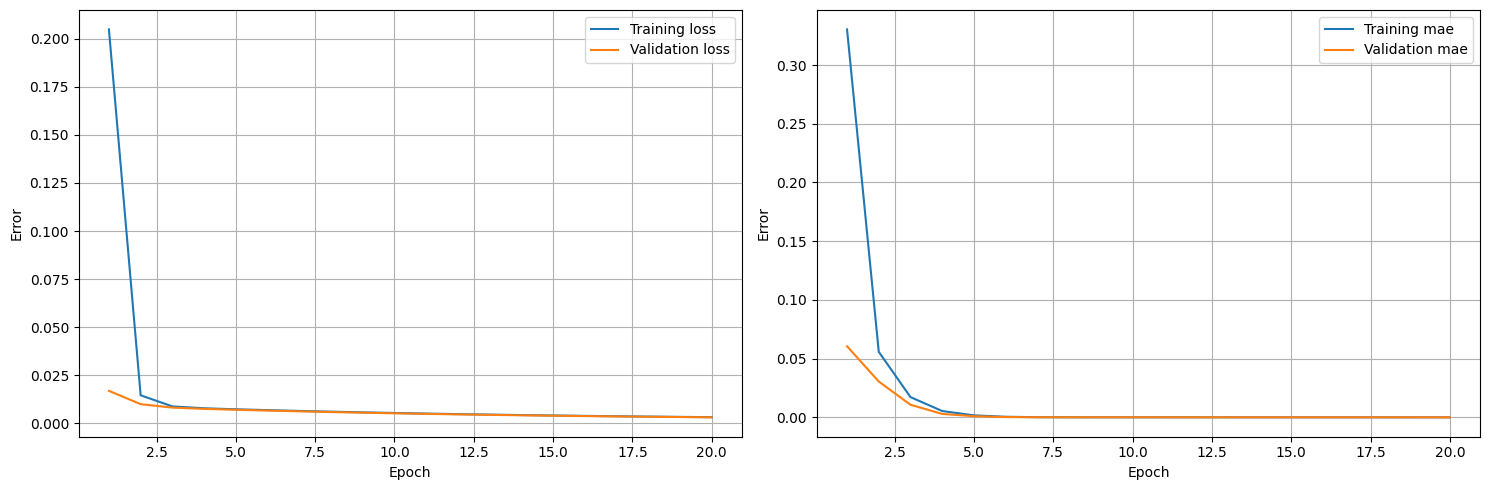

6/6 [==============================] - 0s 33ms/step - loss: 0.0031 - mae: 2.9113e-05
MAE of test data: 2.9e-05
MSE of test data: 0.003137


In [106]:
level_1.train_lstm()

### Hybrid Loss & Error

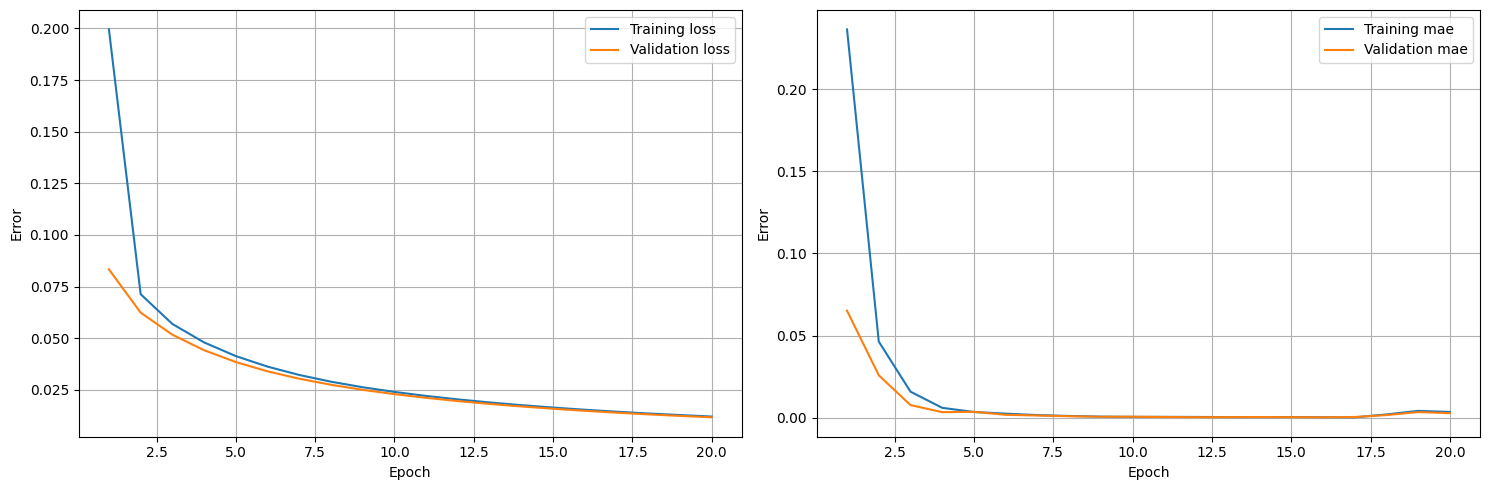

6/6 [==============================] - 0s 61ms/step - loss: 0.0116 - mae: 0.0028
MAE of test data: 0.002781
MSE of test data: 0.01165


In [107]:
level_1.train_hybrid()

### Linear Loss & Error

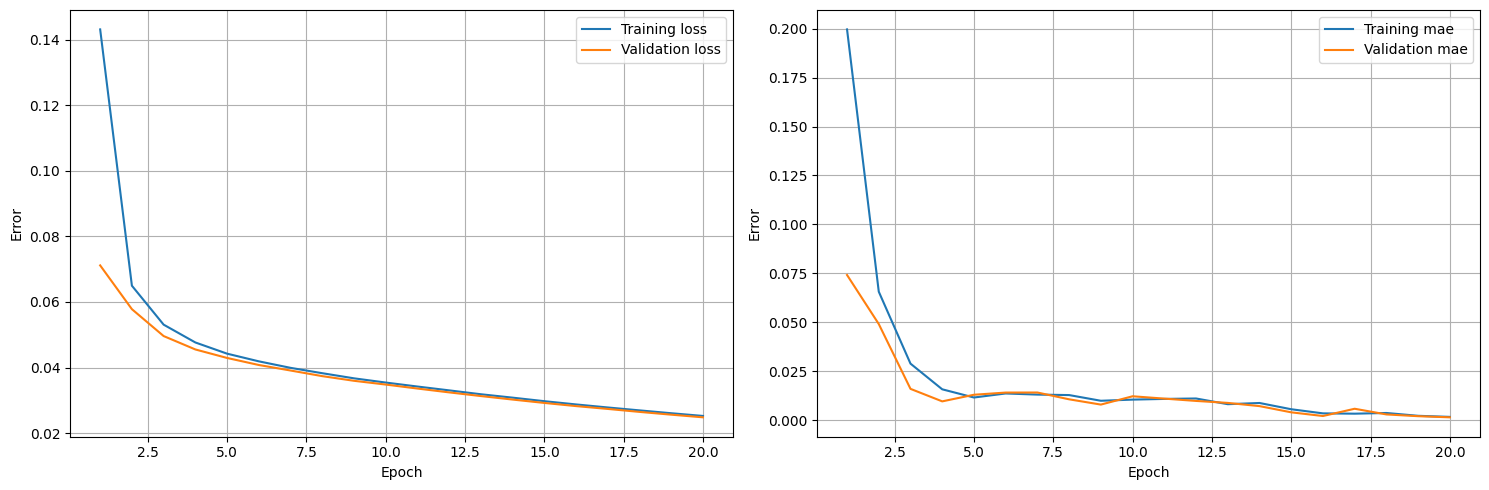

6/6 [==============================] - 0s 46ms/step - loss: 0.0248 - mae: 0.0015
MAE of test data: 0.001497
MSE of test data: 0.024792


In [108]:
level_1.train_linear()

### Example Charts

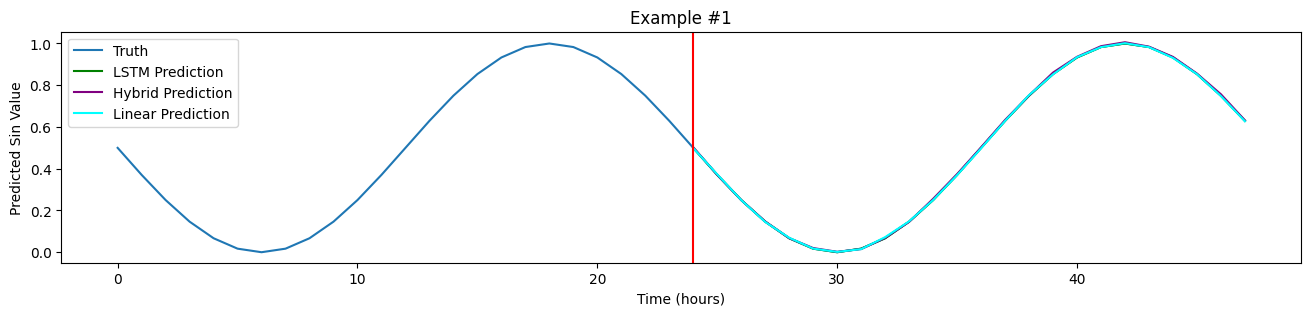

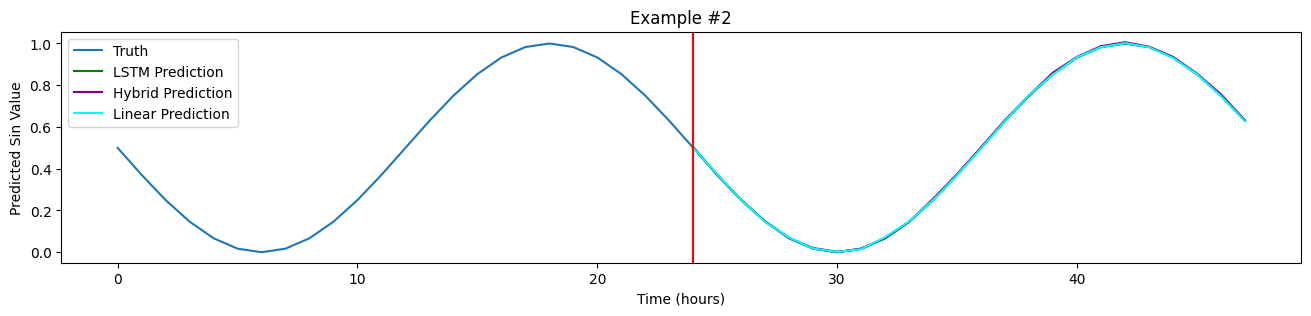

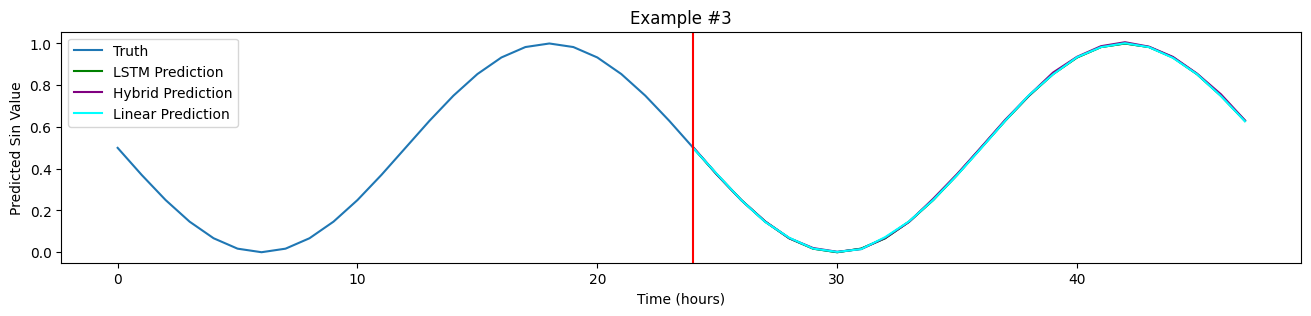

<Figure size 1600x300 with 0 Axes>

In [109]:
level_1.plot_predictions("Predicted Sin Value")

## Ex: Predicting temperature 24 hours into the future only based on time of day and season
We expect the models to **roughly** produce the shape of temperature throughout the day (higher during the day, lower at night).

### Result Summary
Based on the MSE and MAE, and visualy from the graphs, the Linear model tends to follow the shape of the temperature better than the other models. While the other models produce near straight line, but closer to the average temperature.

| Model      | MAE | MSE | Epocs |
| ----------- | ----------- | -| -|
| LSTM      | `4.183916`     | `27.541086` | 200 |
| Hybrid   | `3.817492`        | `24.633385`| 200 (stopped early at 27 epocs) |
| Linear   | `4.037807`        | `24.273764`| 200 (stopped early at 52 epocs) |


### LSTM Loss & Error

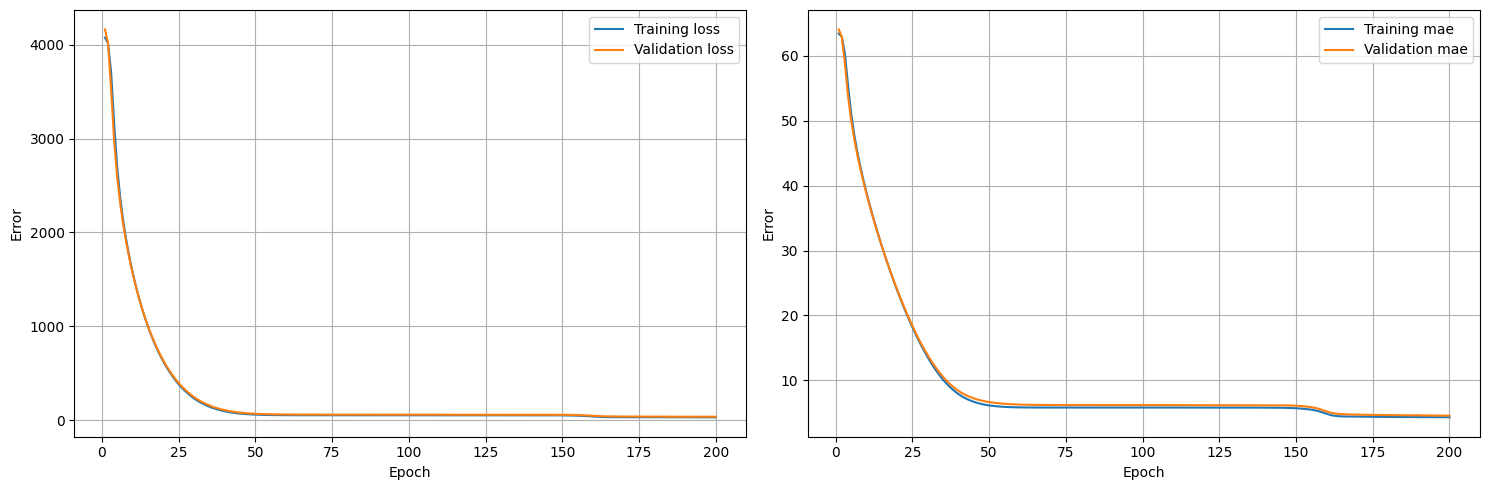

11/11 [==============================] - 0s 22ms/step - loss: 27.5411 - mae: 4.1839
MAE of test data: 4.183916
MSE of test data: 27.541086


In [112]:
level_2.train_lstm()

### Hybrid Loss & Error

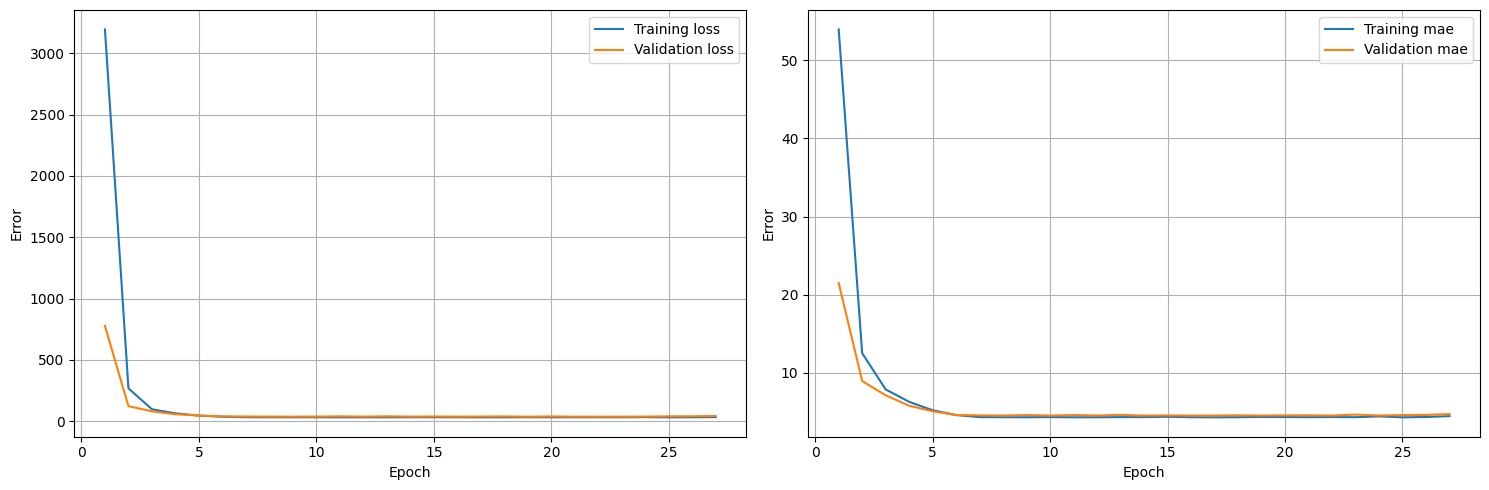

11/11 [==============================] - 1s 63ms/step - loss: 24.6334 - mae: 3.8175
MAE of test data: 3.817492
MSE of test data: 24.633385


In [113]:
level_2.train_hybrid()

### Linear Loss & Error

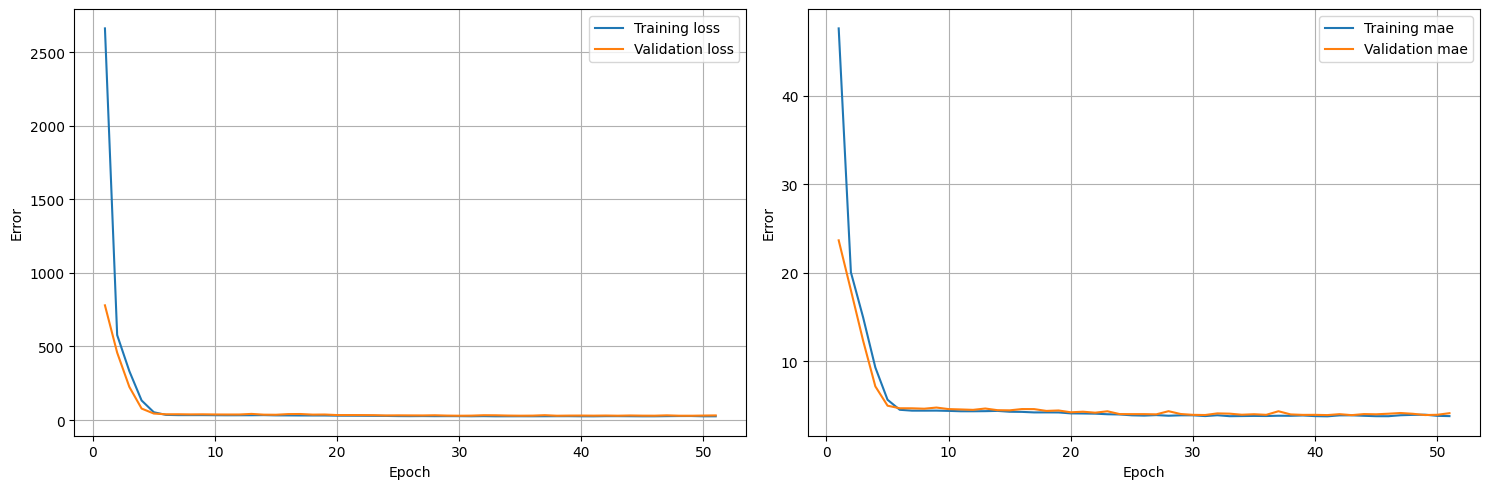

11/11 [==============================] - 1s 48ms/step - loss: 24.2738 - mae: 4.0378
MAE of test data: 4.037807
MSE of test data: 24.273764


In [114]:
level_2.train_linear()

### Example Charts

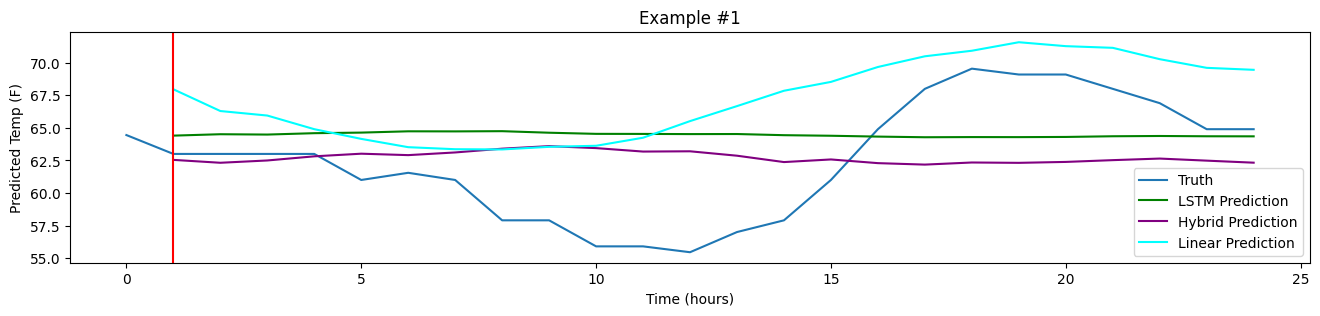

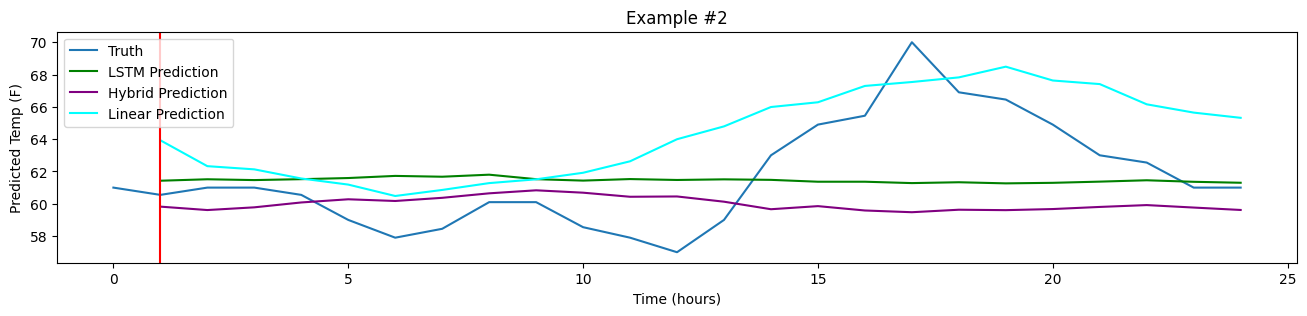

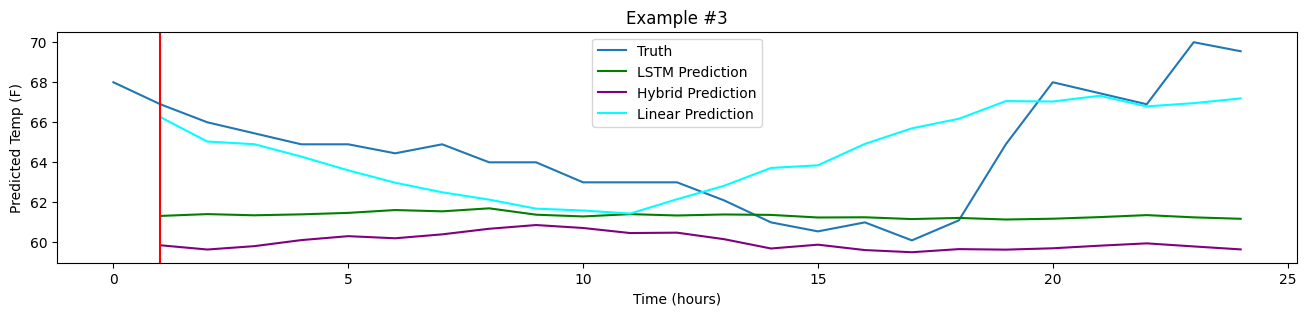

<Figure size 1600x300 with 0 Axes>

In [116]:
level_2.plot_predictions("Predicted Temp (F)")

## Ex: Predicting temperature 24 hours into the future based on time of day, season, and past 24 hours of temp
We expect the models to have a correct shape, shifted around the correct tempature. Yet only follow the pattern of the previous days.

### Result Summary
| Model      | MAE | MSE | Epocs |
| ----------- | ----------- | -| -|
| LSTM      | `5.243341`     | `40.92944` | 200 |
| Hybrid   | `3.038101`        | `13.98365`| 200 (stopped early at 48 epocs) |
| Linear   | `2.338222`        | `9.288586`| 200 (stopped early at 48 epocs) |


### LSTM Loss & Error

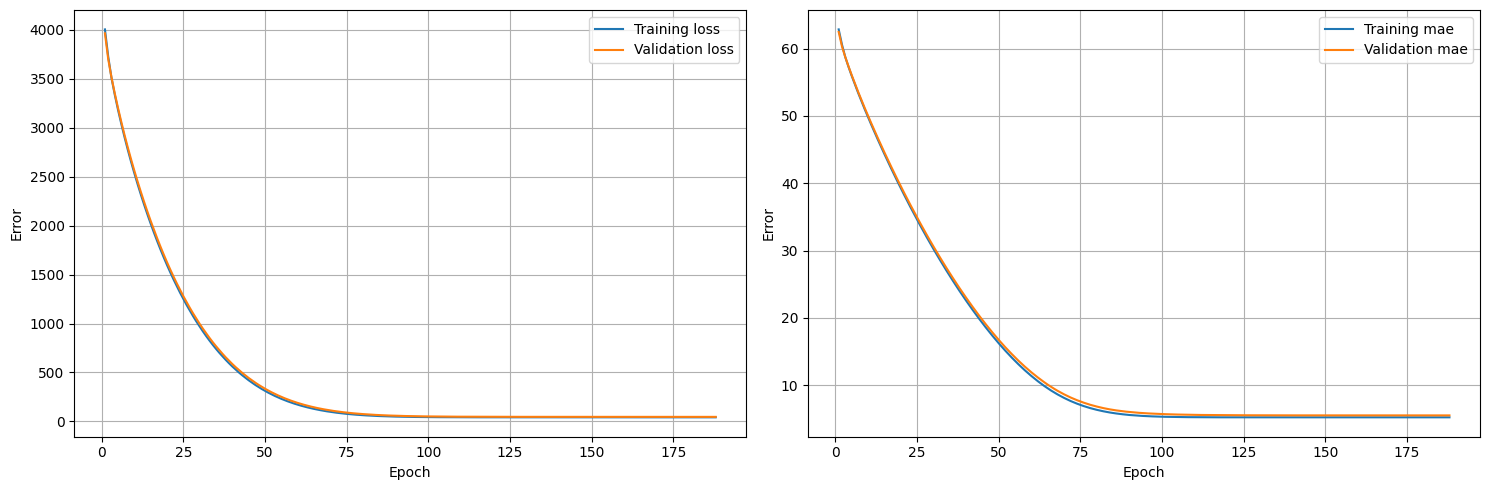

6/6 [==============================] - 0s 28ms/step - loss: 40.9294 - mae: 5.2433
MAE of test data: 5.243341
MSE of test data: 40.92944


In [117]:
level_3.train_lstm()

### Hybrid Loss & Error

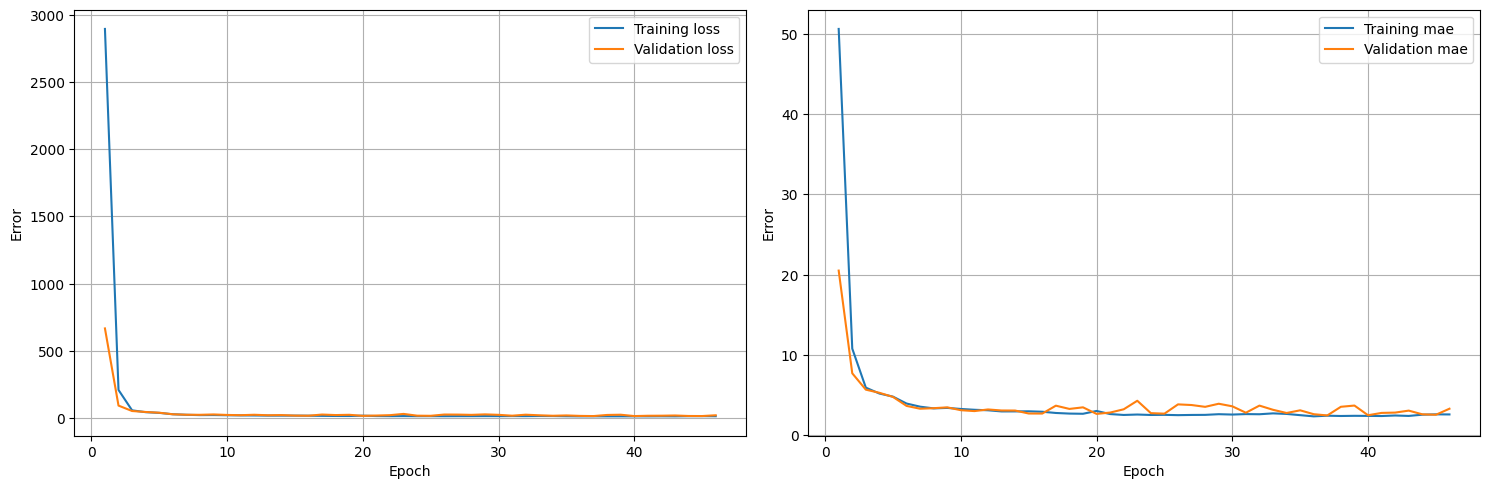

6/6 [==============================] - 0s 52ms/step - loss: 13.9837 - mae: 3.0381
MAE of test data: 3.038101
MSE of test data: 13.98365


In [118]:
level_3.train_hybrid()

### Linear Loss & Error

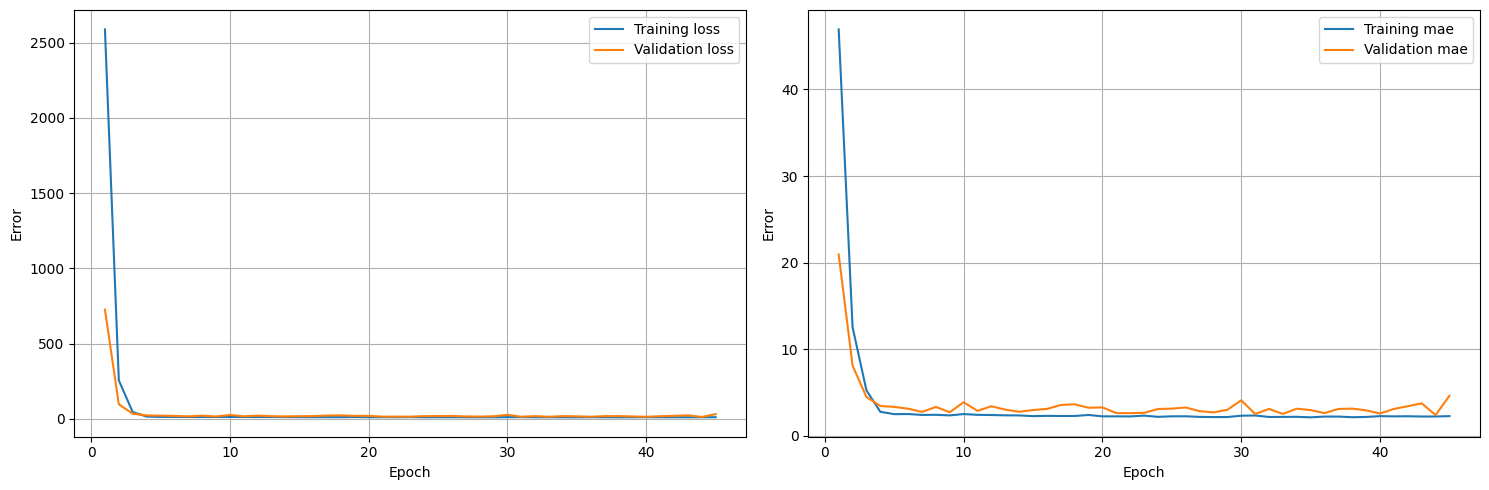

6/6 [==============================] - 0s 40ms/step - loss: 9.2886 - mae: 2.3382
MAE of test data: 2.338222
MSE of test data: 9.288586


In [119]:
level_3.train_linear()

### Example Charts

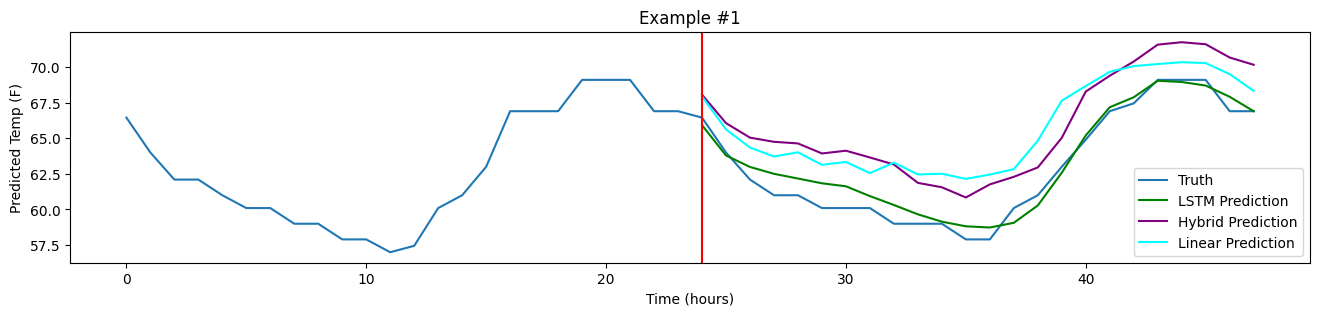

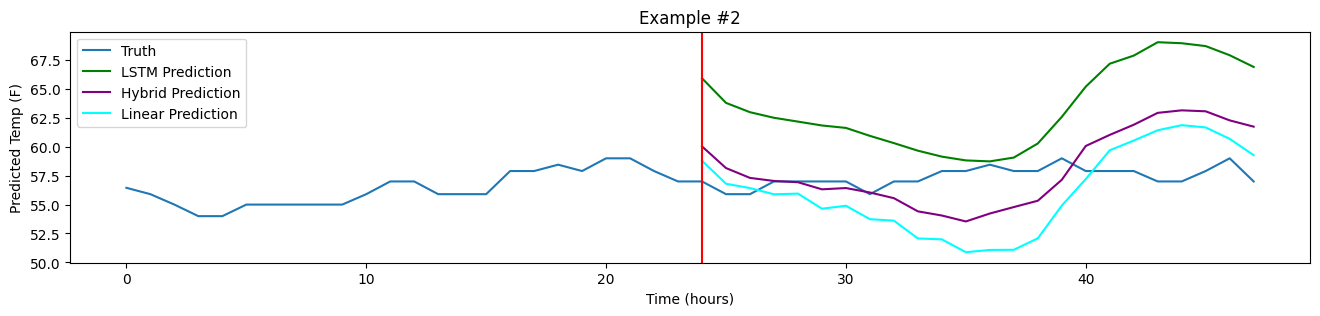

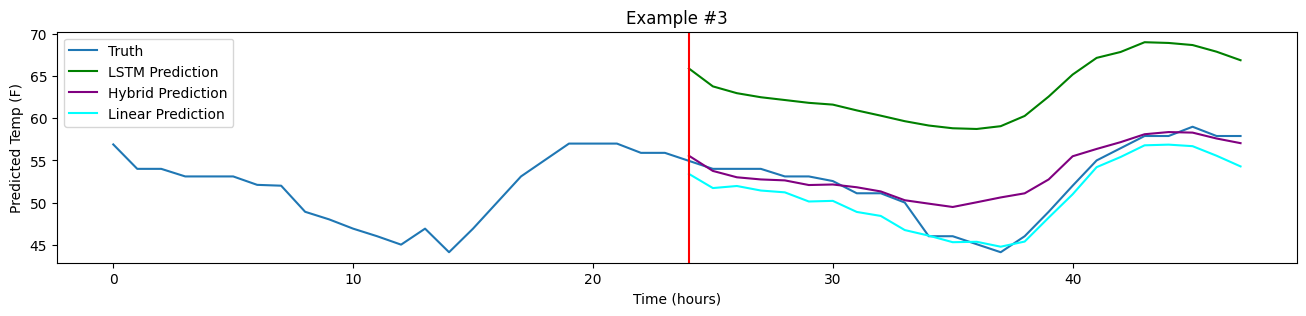

<Figure size 1600x300 with 0 Axes>

In [120]:
level_3.plot_predictions("Predicted Temp (F)")

## Ex: Predicting temperature 24 hours into the future based on all weather metrics at the same weather station, with 24 hours of history
We expect the same pattern as above but slightly more accurate

### Result Summary
| Model      | MAE | MSE |
| ----------- | ----------- | -|
| LSTM      | `5.38`     | `1.234` |
| Hybrid   | `27.34`        | `48`|
| Linear   | `2.34`        | `38`|


### LSTM Loss & Error

In [ ]:
level_1.train_lstm()

11/11 [==============================] - 0s 22ms/step - loss: 534.1255 - mae: 22.0053
MAE of test data: 22.005346298217773
MSE of test data: 534.12548828125


### Hybrid Loss & Error

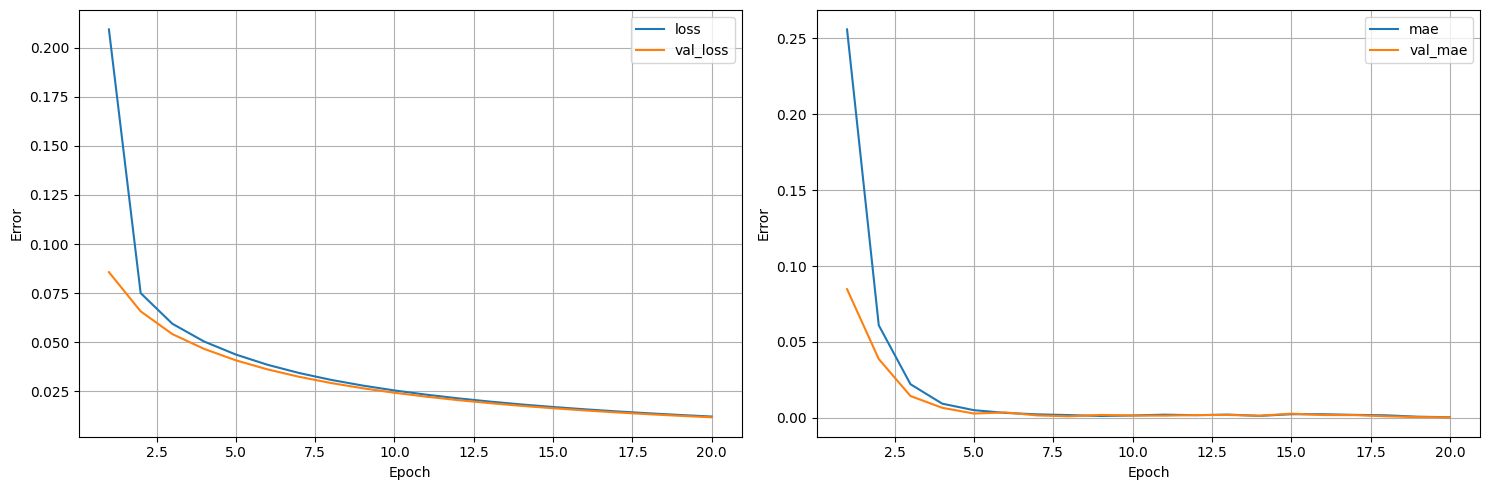

6/6 [==============================] - 0s 54ms/step - loss: 0.0117 - mae: 2.6281e-04
MAE of test data: 0.0002628138172440231
MSE of test data: 0.011722824536263943


In [ ]:
level_1.train_hybrid()

### Linear Loss & Error

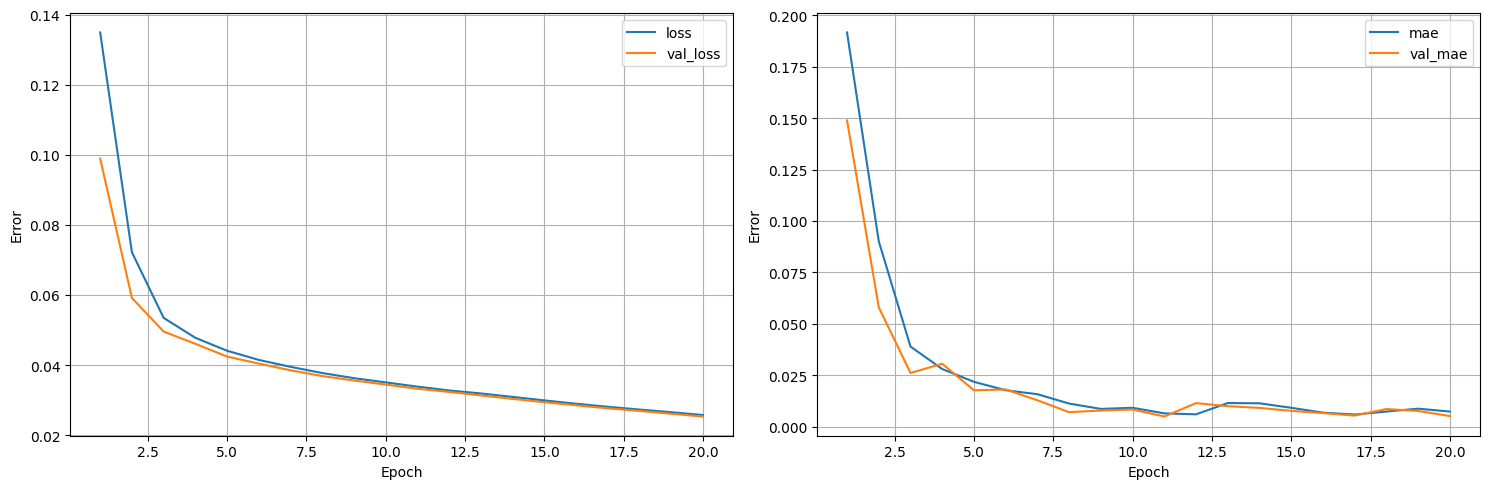

6/6 [==============================] - 0s 41ms/step - loss: 0.0254 - mae: 0.0051
MAE of test data: 0.005113342776894569
MSE of test data: 0.02535470947623253


In [ ]:
level_1.train_linear()

### Example Charts

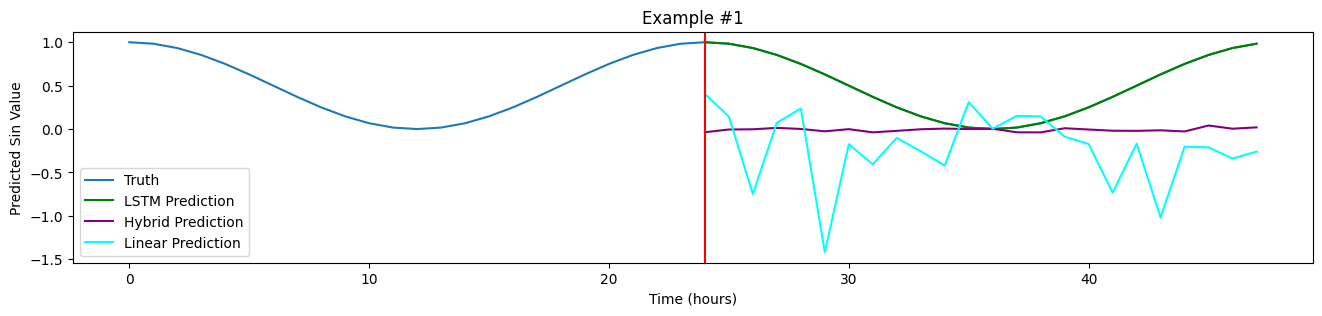

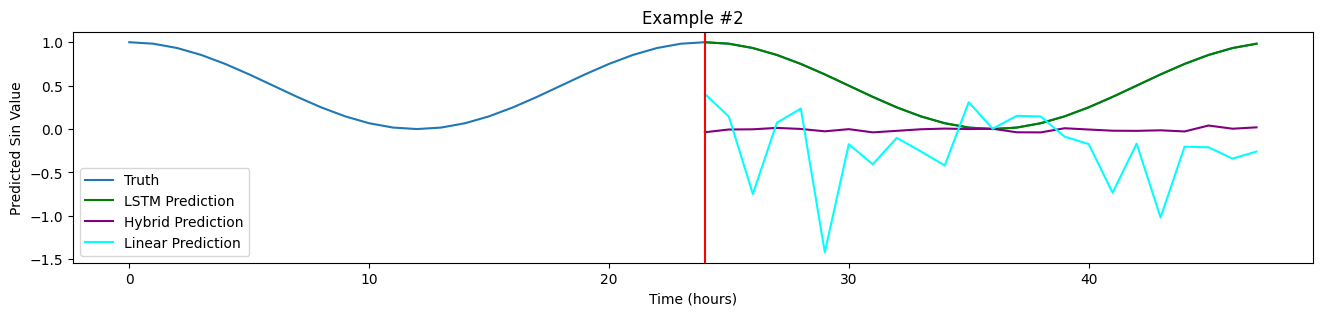

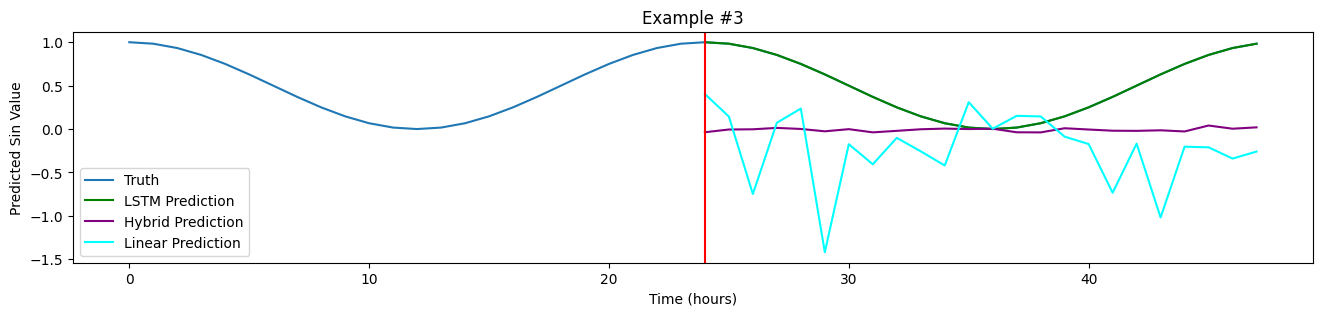

<Figure size 1600x300 with 0 Axes>

In [ ]:
level_1.plot_predictions("Predicted Sin Value")

## Predicting temperature 24 hours into the future based on all weather metrics including 4 other weather stations, with 24 hours of history
We expect the same pattern as above but slightly more accurate

### Result Summary
| Model      | MAE | MSE |
| ----------- | ----------- | -|
| LSTM      | `5.38`     | `1.234` |
| Hybrid   | `27.34`        | `48`|
| Linear   | `2.34`        | `38`|


### LSTM Loss & Error

In [ ]:
level_1.train_lstm()

11/11 [==============================] - 0s 22ms/step - loss: 534.1255 - mae: 22.0053
MAE of test data: 22.005346298217773
MSE of test data: 534.12548828125


### Hybrid Loss & Error

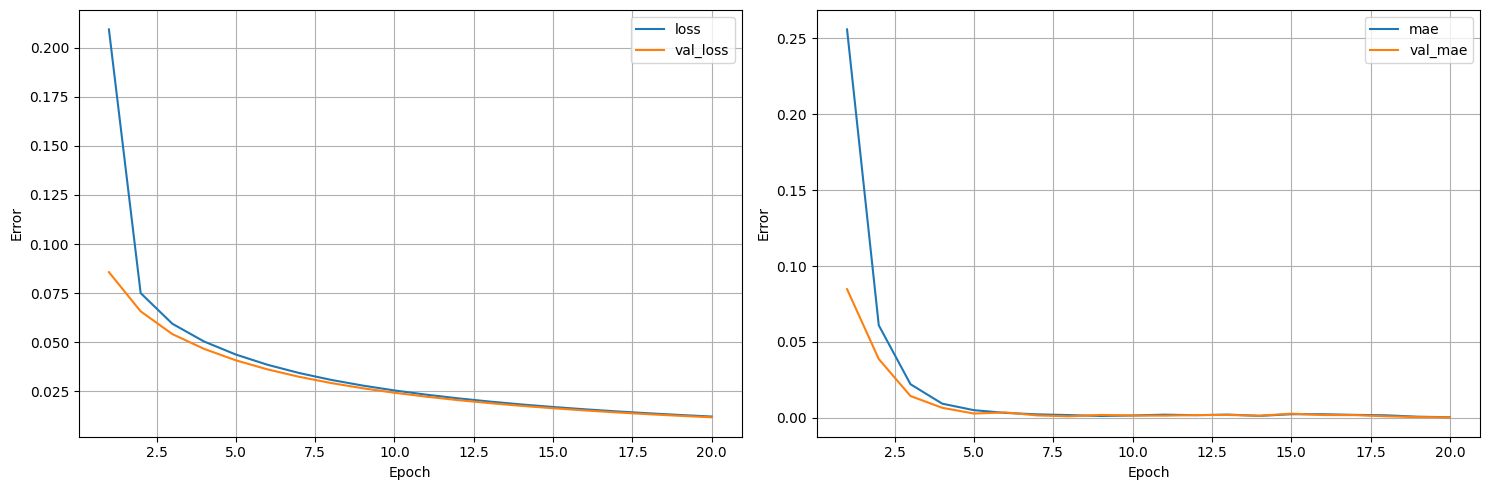

6/6 [==============================] - 0s 54ms/step - loss: 0.0117 - mae: 2.6281e-04
MAE of test data: 0.0002628138172440231
MSE of test data: 0.011722824536263943


In [ ]:
level_1.train_hybrid()

### Linear Loss & Error

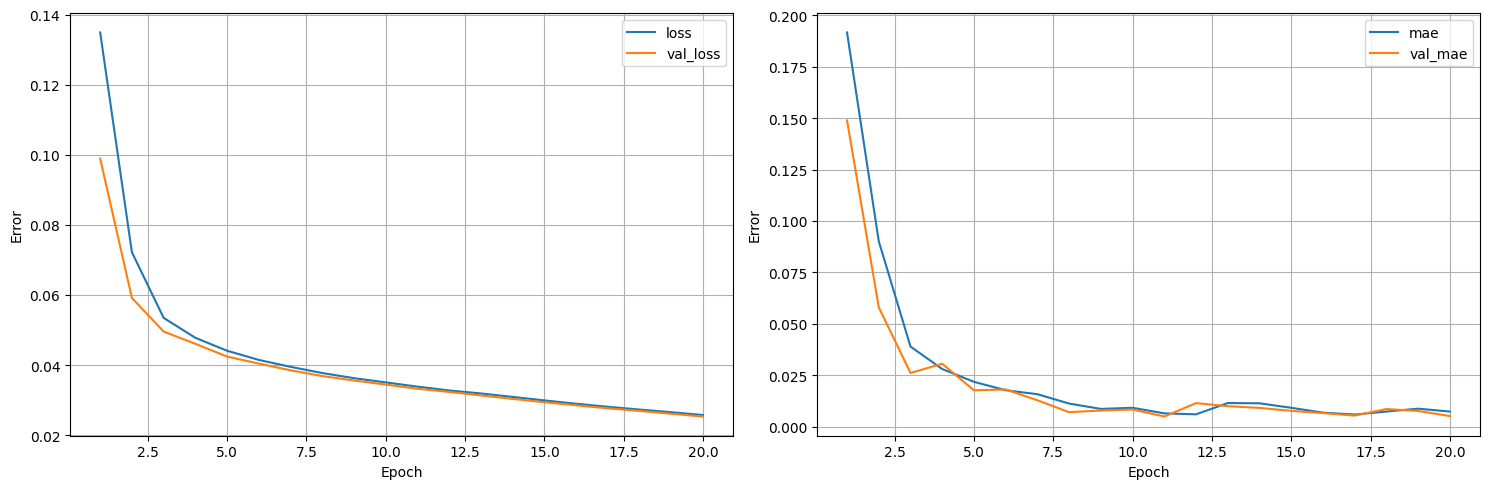

6/6 [==============================] - 0s 41ms/step - loss: 0.0254 - mae: 0.0051
MAE of test data: 0.005113342776894569
MSE of test data: 0.02535470947623253


In [ ]:
level_1.train_linear()

### Example Charts

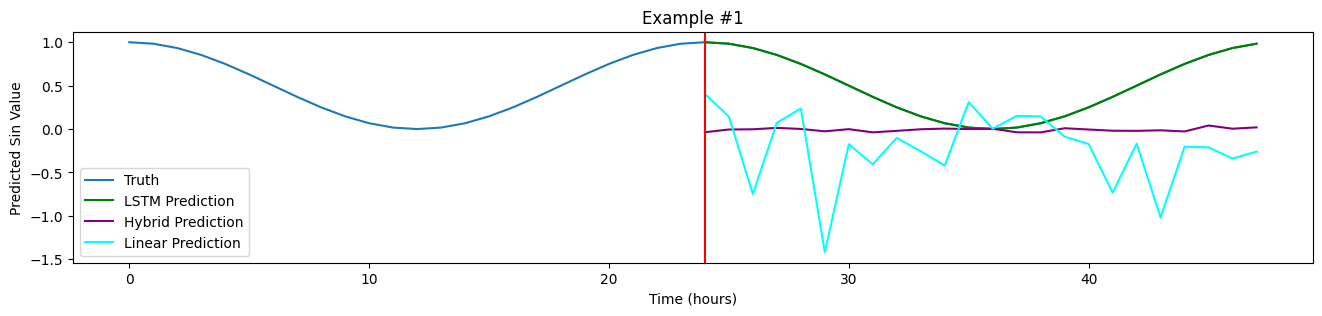

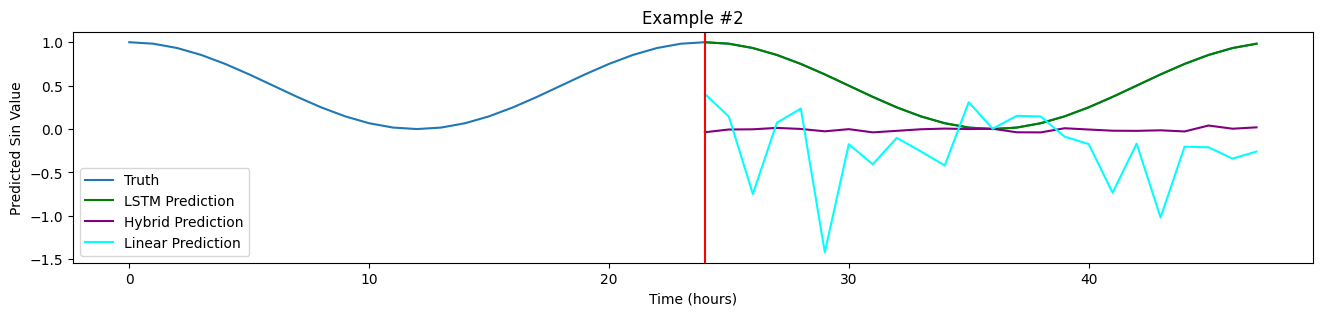

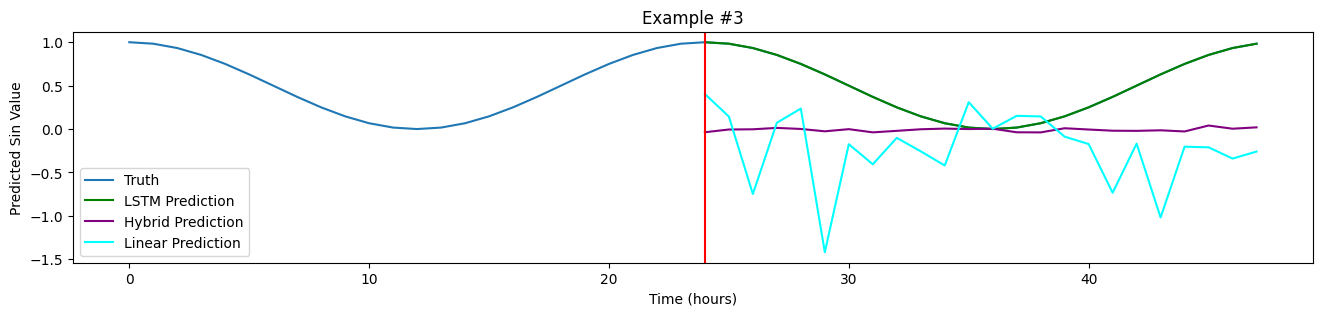

<Figure size 1600x300 with 0 Axes>

In [ ]:
level_1.plot_predictions("Predicted Sin Value")

## Predicting temperature 24 hours into the future based on all weather metrics including 4 other weather stations, with 72 hours of history
We expect the same pattern as above but slightly more accurate

### Result Summary
| Model      | MAE | MSE |
| ----------- | ----------- | -|
| LSTM      | `5.38`     | `1.234` |
| Hybrid   | `27.34`        | `48`|
| Linear   | `2.34`        | `38`|


### LSTM Loss & Error

In [ ]:
level_1.train_lstm()

11/11 [==============================] - 0s 22ms/step - loss: 534.1255 - mae: 22.0053
MAE of test data: 22.005346298217773
MSE of test data: 534.12548828125


### Hybrid Loss & Error

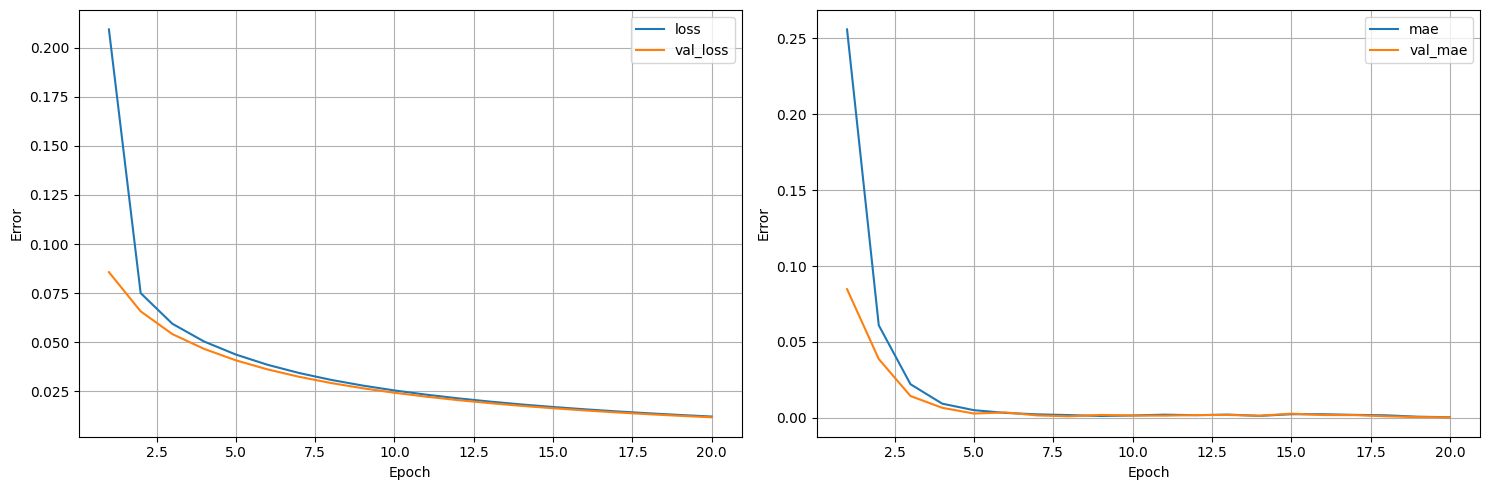

6/6 [==============================] - 0s 54ms/step - loss: 0.0117 - mae: 2.6281e-04
MAE of test data: 0.0002628138172440231
MSE of test data: 0.011722824536263943


In [ ]:
level_1.train_hybrid()

### Linear Loss & Error

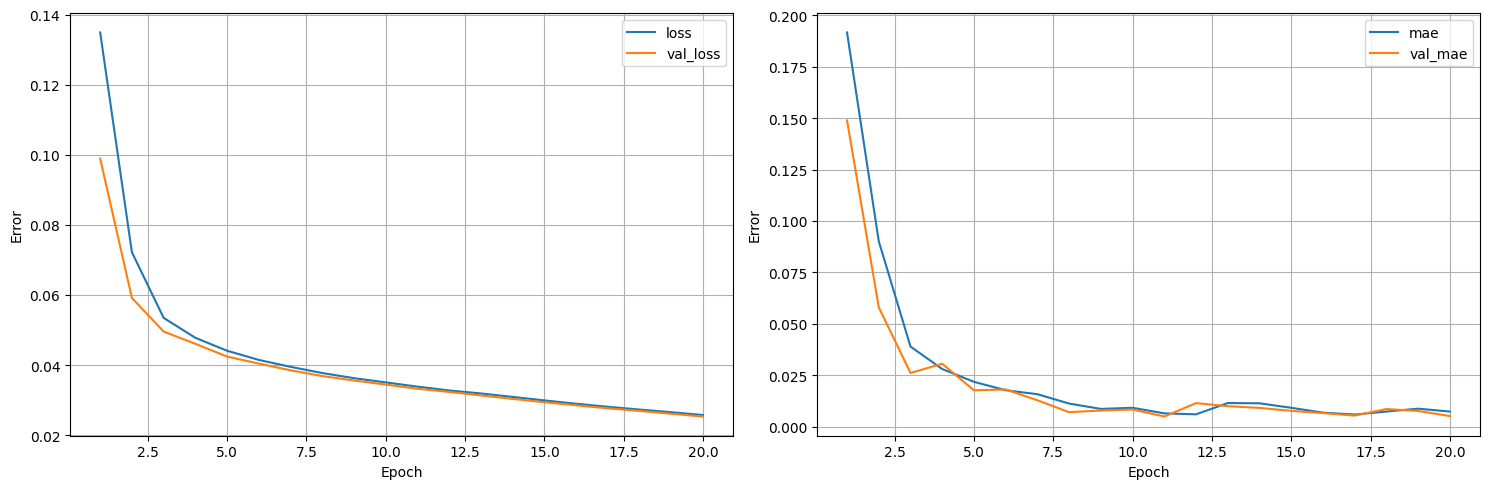

6/6 [==============================] - 0s 41ms/step - loss: 0.0254 - mae: 0.0051
MAE of test data: 0.005113342776894569
MSE of test data: 0.02535470947623253


In [ ]:
level_1.train_linear()

### Example Charts

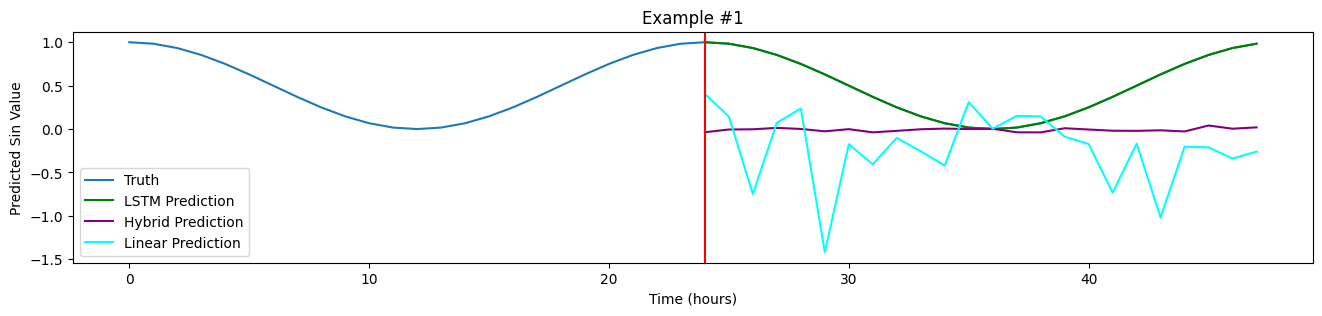

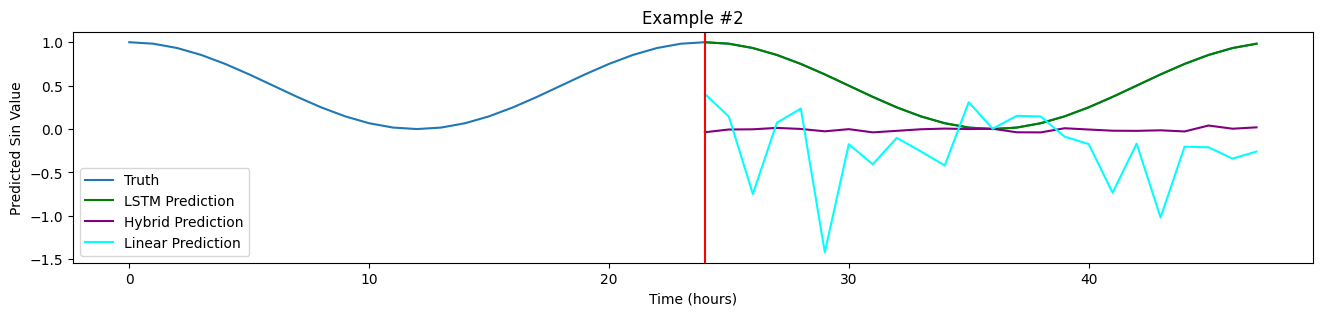

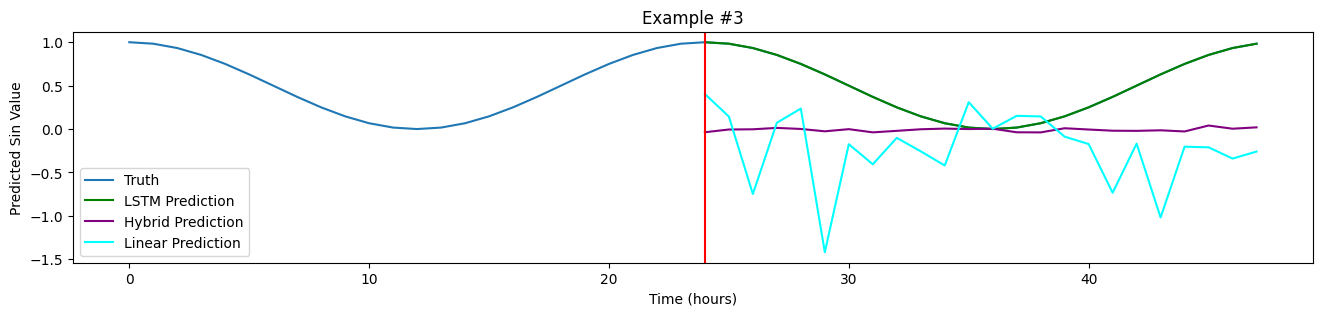

<Figure size 1600x300 with 0 Axes>

In [ ]:
level_1.plot_predictions("Predicted Sin Value")